## IMPORT LIBRARIES

In [39]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, cross_val_score
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier

sns.set_style()

# IGNORE WARNINGS
import warnings
warnings.filterwarnings('ignore')

np.random.seed(2022)

In [40]:
# LOAD THE DATE AS A DATAFRAME
df = pd.read_csv('acquisition_train.csv')

In [41]:
# PRINT FIVE SAMPLES
df.head()

,ids,target_default,score_1,score_2,score_3,score_4,score_5,score_6,risk_rate,last_amount_borrowed,...,external_data_provider_fraud_score,lat_lon,marketing_channel,profile_phone_number,reported_income,shipping_state,shipping_zip_code,profile_tags,user_agent,target_fraud
0,343b7e7b-2cf8-e508-b8fd-0a0285af30aa,False,1Rk8w4Ucd5yR3KcqZzLdow==,IOVu8au3ISbo6+zmfnYwMg==,350.0,101.800832,0.259555,108.427273,0.40,25033.92,...,645,"(-29.151545708122246, -51.1386461804385)",Invite-email,514-9840782,57849.0,BR-MT,17528,"{'tags': ['n19', 'n8']}",Mozilla/5.0 (Linux; Android 6.0.1; SGP771 Buil...,NaN
1,bc2c7502-bbad-0f8c-39c3-94e881967124,False,DGCQep2AE5QRkNCshIAlFQ==,SaamrHMo23l/3TwXOWgVzw==,370.0,97.062615,0.942655,92.002546,0.24,NaN,...,243,"(-19.687710705798963, -47.94151536525154)",Radio-commercial,251-3659293,4902.0,BR-RS,40933,"{'tags': ['n6', 'n7', 'nim']}",Mozilla/5.0 (Linux; Android 5.0.2; SAMSUNG SM-...,NaN
2,669630dd-2e6a-0396-84bf-455e5009c922,True,DGCQep2AE5QRkNCshIAlFQ==,Fv28Bz0YRTVAT5kl1bAV6g==,360.0,100.027073,0.351918,112.892453,0.29,7207.92,...,65,"(-28.748023890412284, -51.867279334353995)",Waiting-list,230-6097993,163679.0,BR-RR,50985,"{'tags': ['n0', 'n17', 'nim', 'da']}",Mozilla/5.0 (Linux; Android 6.0.1; SGP771 Buil...,NaN
3,d235609e-b6cb-0ccc-a329-d4f12e7ebdc1,False,1Rk8w4Ucd5yR3KcqZzLdow==,dCm9hFKfdRm7ej3jW+gyxw==,510.0,101.599485,0.987673,94.902491,0.32,NaN,...,815,"(-17.520650158450454, -39.75801139933186)",Waiting-list,261-3543751,1086.0,BR-RN,37825,{'tags': ['n4']},Mozilla/5.0 (Linux; Android 6.0; HTC One X10 B...,NaN
4,9e0eb880-e8f4-3faa-67d8-f5cdd2b3932b,False,8k8UDR4Yx0qasAjkGrUZLw==,+CxEO4w7jv3QPI/BQbyqAA==,500.0,98.474289,0.532539,118.126207,0.18,NaN,...,320,"(-16.574259446978008, -39.90990074785962)",Invite-email,102-3660162,198618.0,BR-MT,52827,"{'tags': ['pro+aty', 'n19', 'da', 'b19']}",Mozilla/5.0 (Linux; Android 7.0; Pixel C Build...,NaN


## Data Analysis

* We observe the data for basic statistical properties such as
    * Number of features
    * Number of data examples / applicants
    * Distributions
* We check the dataset for existence of : 
    * outliers
    * missing values

In [42]:
# PRINT SHAPE OF THE DATAFRAME
print('Number of rows: ', df.shape[0])
print('Number of columns: ', df.shape[1])

Number of rows:  45000
Number of columns:  43


The statistic above reveals that the dataset contains 43 disticnt features and 45000 training examples examples i.e clients.
target_default is a boolean feature (True/False) and its the target variable.

In [43]:
# PRINT GENERAL INFO ABOUT THE DATA
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 43 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   ids                                               45000 non-null  object 
 1   target_default                                    41741 non-null  object 
 2   score_1                                           44438 non-null  object 
 3   score_2                                           44438 non-null  object 
 4   score_3                                           44438 non-null  float64
 5   score_4                                           45000 non-null  float64
 6   score_5                                           45000 non-null  float64
 7   score_6                                           45000 non-null  float64
 8   risk_rate                                         44438 non-null  float64
 9   last_amount_borro

    The general information above, reveals that some features have missing values.

In [44]:
# PRINT MISSING VALUES AS A PERCENTAGE
print((df.isnull().sum() * 100 / df.shape[0]).sort_values(ascending=False))

target_fraud                                        96.617778
last_amount_borrowed                                66.568889
last_borrowed_in_months                             66.568889
ok_since                                            58.988889
external_data_provider_credit_checks_last_2_year    50.284444
external_data_provider_credit_checks_last_year      33.608889
credit_limit                                        30.666667
n_issues                                            25.653333
facebook_profile                                     9.906667
marketing_channel                                    7.951111
job_name                                             7.413333
target_default                                       7.242222
external_data_provider_email_seen_before             4.962222
lat_lon                                              3.028889
user_agent                                           1.604444
n_bankruptcies                                       1.548889
n_defaul

From the statistic above, observe that target_default has a number of missing values. This is the dependent variable, therefore  we don't have options for imputation we therefore eliminate all entries where target_default is null

In [8]:
df.dropna(subset=['target_default'], inplace=True)

Almost all examples of target_fraud are null, ie 96%, this feature is not much important to this project, so we drop

In [9]:
# DROP 'target_fraud'
df.drop('target_fraud', axis=1, inplace=True)

Examining the number of unique values for each feature.

In [10]:
# PRINT NUMBER OF UNIQUE ENTRIES
df.nunique().sort_values()

channel                                                 1
external_data_provider_credit_checks_last_2_year        1
last_borrowed_in_months                                 2
target_default                                          2
facebook_profile                                        2
external_data_provider_credit_checks_last_year          2
external_data_provider_credit_checks_last_month         4
real_state                                              5
n_defaulted_loans                                       5
email                                                   6
n_bankruptcies                                          6
score_1                                                 7
marketing_channel                                       9
shipping_state                                         25
score_2                                                35
n_issues                                               44
n_accounts                                             44
state         

As it can be seen, the independent features channel and external_data_provider_credit_checks_last_2_year have only one value. 
The entries are same for all clients, hence not useful fot the project, we drop the two features

In [11]:
# DROP channel AND external_data_provider_credit_checks_last_2_year
df.drop(labels=['channel', 'external_data_provider_credit_checks_last_2_year'], axis=1, inplace=True)

To make the data as adequate to the problem as possible, we drop some additional columns that are not adding value to the model.

In [12]:
df.drop(labels=['email', 'reason', 'zip', 'job_name', 'external_data_provider_first_name', 'lat_lon',
                       'shipping_zip_code', 'user_agent', 'profile_tags', 'marketing_channel',
                       'profile_phone_number', 'application_time_applied', 'ids'], axis=1, inplace=True)

## Outlier analysis

In [13]:
# PRINT DESCRIPTIVE STATISTIC
df.describe()

,score_3,score_4,score_5,score_6,risk_rate,last_amount_borrowed,last_borrowed_in_months,credit_limit,income,ok_since,n_bankruptcies,n_defaulted_loans,n_accounts,n_issues,application_time_in_funnel,external_data_provider_credit_checks_last_month,external_data_provider_credit_checks_last_year,external_data_provider_email_seen_before,external_data_provider_fraud_score,reported_income
count,41741.000000,41741.000000,41741.000000,41741.000000,41741.000000,14133.000000,14133.000000,28632.000000,4.174100e+04,17276.000000,41606.000000,41729.000000,41741.000000,30818.000000,41741.000000,41741.000000,27720.000000,39656.000000,41741.000000,41741.0
mean,346.459836,100.006820,0.499416,99.919399,0.294451,13328.104095,40.588410,33877.220453,7.108012e+04,35.192174,0.076696,0.004625,10.639108,11.023882,247.748545,1.504396,0.504185,12.731188,500.491771,inf
std,110.102271,3.183821,0.288085,10.022703,0.101561,7918.698433,9.437936,36141.985884,5.225978e+04,21.629577,0.274820,0.080157,4.588175,4.596036,146.326172,1.114207,0.499992,125.711218,287.993121,NaN
min,0.000000,86.191572,0.000035,60.663039,0.000000,1005.180000,36.000000,0.000000,4.821180e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-999.000000,0.000000,403.0
25%,270.000000,97.862546,0.251595,93.182517,0.220000,7210.280000,36.000000,9975.000000,4.401958e+04,17.000000,0.000000,0.000000,7.000000,8.000000,120.000000,1.000000,0.000000,11.000000,252.000000,50910.0
50%,340.000000,100.017950,0.500174,99.977774,0.290000,12011.050000,36.000000,25213.000000,6.004409e+04,32.000000,0.000000,0.000000,10.000000,10.000000,248.000000,2.000000,1.000000,27.000000,502.000000,101623.0
75%,420.000000,102.143100,0.747630,106.630991,0.360000,18030.160000,36.000000,46492.500000,8.503289e+04,50.000000,0.000000,0.000000,13.000000,14.000000,375.000000,2.000000,1.000000,43.000000,747.000000,151248.0
max,990.000000,113.978234,0.999973,142.192400,0.900000,35059.600000,60.000000,448269.000000,5.000028e+06,141.000000,5.000000,5.000000,49.000000,49.000000,500.000000,3.000000,1.000000,59.000000,1000.000000,inf


In [44]:
# COUNT OCCURENCES OF 'f'ENTRIES IN "reported_income"
np.isinf(df['reported_income']).sum()

66

In [14]:
# COUNT OCCURENCES OF -999 IN 'external_data_provider_email_seen_before'
df.loc[df['external_data_provider_email_seen_before'] == -999, 'external_data_provider_email_seen_before'].value_counts()

-999.0    591
Name: external_data_provider_email_seen_before, dtype: int64

From the statistic above, its observed that reported_income has 66 'inf' values, external_data_provider_email_seen_before has 591 -999 values.
We replace these values with NaN, to aid plotting histograms for visualizizing the distributions.

In [15]:
# REPLACE EACH OCCURENCE OF 'inf' WITH 'nan'
df['reported_income'] = df['reported_income'].replace(np.inf, np.nan)

# REPLCE EACH OCCURENCE OF ''-999' WITH 'nan'
df.loc[df['external_data_provider_email_seen_before'] == -999, 'external_data_provider_email_seen_before'] = np.nan

Create a dataframe consisting of only numerical features, Their histogram  helps us examine the properties of distributions

In [16]:
# NUMERICAL DATAFRAME
df_numerical = df[['score_3', 'risk_rate', 'last_amount_borrowed', 
                                 'last_borrowed_in_months', 'credit_limit', 'income', 'ok_since', 
                                 'n_bankruptcies', 'n_defaulted_loans', 'n_accounts', 'n_issues', 
                                 'external_data_provider_email_seen_before']]

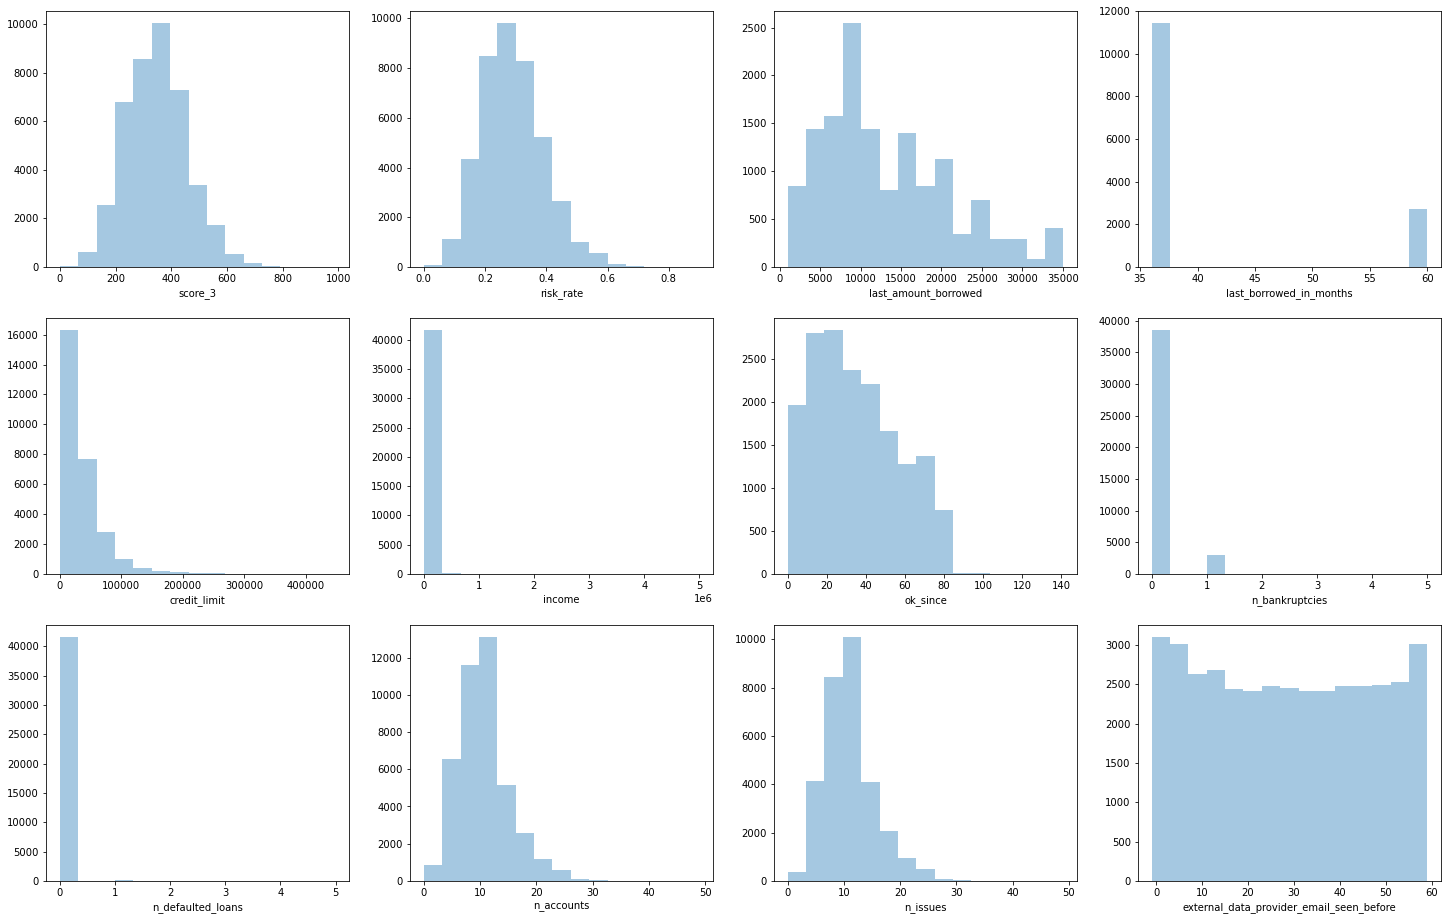

In [17]:
# HISTOGRAM FOR NUMERICAL FEATURES

nrows = 3
ncols = 4

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(25, 16))

r = 0
c = 0

for i in df_numerical:
    sns.distplot(df_numerical[i], bins=15,kde=False, ax=ax[r][c])
    if c == ncols - 1:
        r += 1
        c = 0
        
    else:
        c += 1

plt.show()

From the distribution plots, its revealed that the numerical features have missing values that need to be treated.They skewed distribution, indicates that we need to impute the missing values with the median value for each feature.

We perfor imputation according to the following:

*   Categorical variables are filled with the most recurrent value (median).
*   Numerical variables are filled with their median values.
*   In cases of 'last_amount_borrowed', 'last_borrowed_in_months' and 'n_issues' missing values are filled with 0, because its valid to hypothesize that not every client would have values assigned to these variables.

In [18]:
df_num = df.select_dtypes(exclude='object').columns
df_cat = df.select_dtypes(include='object').columns

# IMPUTE 'last_amount_borrowed', 'last_borrowed_in_months' AND 'n_issues'
df['last_amount_borrowed'].fillna(value=0, inplace=True)
df['last_borrowed_in_months'].fillna(value=0, inplace=True)
df['n_issues'].fillna(value=0, inplace=True)

# PERFORM IMPUTATION FOR NUMERICAL FEATURES
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
imputer = imputer.fit(df.loc[:, df_num])
df.loc[:, df_num] = imputer.transform(df.loc[:, df_num])

# IMPUTATION FOR NORMINAL FEATURES
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imputer = imputer.fit(df.loc[:, df_cat])
df.loc[:, df_cat] = imputer.transform(df.loc[:, df_cat])

In [19]:
df.isnull().sum()

target_default                                     0
score_1                                            0
score_2                                            0
score_3                                            0
score_4                                            0
score_5                                            0
score_6                                            0
risk_rate                                          0
last_amount_borrowed                               0
last_borrowed_in_months                            0
credit_limit                                       0
income                                             0
facebook_profile                                   0
state                                              0
real_state                                         0
ok_since                                           0
n_bankruptcies                                     0
n_defaulted_loans                                  0
n_accounts                                    

We now have a  clean data set

Data preprocessing, invlves converting categorical features into numerical values. Sklearn 'LabelEncoder' is used for the binary features while pandas 'get_dummies' is used for the other multiclass categorical features.

In [20]:
bin_var = df.nunique()[df.nunique() == 2].keys().tolist()
num_var = [col for col in df.select_dtypes(['int', 'float']).columns.tolist() if col not in bin_var]
cat_var = [col for col in df.select_dtypes(['object']).columns.tolist() if col not in bin_var]

df_encoded = df.copy()

# LABEL ENCODING
le = LabelEncoder()
for col in bin_var:
    df_encoded[col] = le.fit_transform(df_encoded[col])

# CREATING DUMMY VARIABLES
df_encoded = pd.get_dummies(df_encoded, columns=cat_var)

df_encoded.head()

,target_default,score_3,score_4,score_5,score_6,risk_rate,last_amount_borrowed,last_borrowed_in_months,credit_limit,income,...,shipping_state_BR-PE,shipping_state_BR-PR,shipping_state_BR-RN,shipping_state_BR-RO,shipping_state_BR-RR,shipping_state_BR-RS,shipping_state_BR-SC,shipping_state_BR-SE,shipping_state_BR-SP,shipping_state_BR-TO
0,0,350.0,101.800832,0.259555,108.427273,0.40,25033.92,36.0,0.0,65014.12,...,0,0,0,0,0,0,0,0,0,0
1,0,370.0,97.062615,0.942655,92.002546,0.24,0.00,0.0,39726.0,100018.91,...,0,0,0,0,0,1,0,0,0,0
2,1,360.0,100.027073,0.351918,112.892453,0.29,7207.92,36.0,25213.0,65023.65,...,0,0,0,0,1,0,0,0,0,0
3,0,510.0,101.599485,0.987673,94.902491,0.32,0.00,0.0,54591.0,68830.01,...,0,0,1,0,0,0,0,0,0,0
4,0,500.0,98.474289,0.532539,118.126207,0.18,0.00,0.0,25213.0,60011.29,...,0,0,0,0,0,0,0,0,0,0


After encoding we get 144 columns of features

## Machine Learning Models

We are experimenting with the following 2 boosting algorithms and one ensembe algorithm to determine which one yields better results:


*   XGBoost
*   LightGBM
*   RandomForestClassifier

In [21]:
# EXTRACT X (independent) AND y (dependent) FEATURES
X = df_encoded.drop('target_default', axis=1)
y = df_encoded['target_default']

# SPLIT THE DATA INTO TRAIN AND TEST SETS
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, stratify=y)

In [22]:
X.columns[:20]

Index(['score_3', 'score_4', 'score_5', 'score_6', 'risk_rate',
       'last_amount_borrowed', 'last_borrowed_in_months', 'credit_limit',
       'income', 'facebook_profile', 'ok_since', 'n_bankruptcies',
       'n_defaulted_loans', 'n_accounts', 'n_issues',
       'application_time_in_funnel',
       'external_data_provider_credit_checks_last_month',
       'external_data_provider_credit_checks_last_year',
       'external_data_provider_email_seen_before',
       'external_data_provider_fraud_score'],
      dtype='object')

In [23]:
# STANDARDIZ NUMERICAL FEATURES - faster traning and better performance
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

# PERFORM RESAMPLING - to balance the dataset
rus = RandomUnderSampler()
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

To evaluate the models 'Precision', 'Recall', and 'F1 Score' evalutation metricsare used.


*   **Precision** gives the proportion of positive identifications that were indeed correct.

*   **Recall** determines the proportion of real positives that were 
correctly identified.

*   **F1 Score** is a metric that is useful when we need to seek a balance between precision and recall.

Cross-Validation is used to attain better results.

In [25]:
# DEFINE A FUNCTION FOR MODEL PIPELINE
def val_model(X, y, clf, show=True):
    
    X = np.array(X)
    y = np.array(y)

    pipeline = make_pipeline(StandardScaler(), clf)
    scores = cross_val_score(pipeline, X, y, scoring='recall')

    if show == True:
        print(f'Recall: {scores.mean()}, {scores.std()}')
    
    return scores.mean()

### Training the classifiers with default parameters

In [26]:
# CREATE MODEL INSTANCES
xgb = XGBClassifier()
lgb = LGBMClassifier()
rfc = RandomForestClassifier()

model = []
recall = []

for clf in (xgb, lgb, rfc):
    model.append(clf.__class__.__name__)
    recall.append(val_model(X_train_rus, y_train_rus, clf, show=False))

pd.DataFrame(data=recall, index=model, columns=['Recall'])

[14:38:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:38:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:38:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:38:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

,Recall
XGBClassifier,0.629704
LGBMClassifier,0.635310
RandomForestClassifier,0.642515


As it can be seen all models produced almost same results. We use Cross validation to improve the perforamance.

### XGBoost

In [27]:
# XGBoost
xgb = XGBClassifier()

# PARAMETERS TO SEARCH FOR OPTIMALITY
param_grid = {'n_estimators': range(0,1000,50)}
  
kfold = StratifiedKFold(n_splits=3, shuffle=True)
grid_search = GridSearchCV(xgb, param_grid, scoring="recall", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train_rus, y_train_rus)

print(f'Best result: {grid_result.best_score_} for {grid_result.best_params_}')

[14:54:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best result: 0.6309086998162629 for {'n_estimators': 50}


In [28]:
# XGBoost
xgb = XGBClassifier(n_estimators=50)

# PARAMETERS TO SEARCH FOR OPTIMALITY
param_grid = {'max_depth': [1, 3, 5],
              'min_child_weight': [1, 3, 6]}

kfold = StratifiedKFold(n_splits=3, shuffle=True)
grid_search = GridSearchCV(xgb, param_grid, scoring="recall", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train_rus, y_train_rus)

print(f'Best result: {grid_result.best_score_} for {grid_result.best_params_}')

[14:55:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best result: 0.652120788255242 for {'max_depth': 1, 'min_child_weight': 1}


In [29]:
# XGBoost
xgb = XGBClassifier(n_estimators=50, max_depth=3, min_child_weight=6)

# PARAMETERS TO SEARCH FOR OPTIMALITY
param_grid = {'gamma': [0, 1, 5]}
  
kfold = StratifiedKFold(n_splits=3, shuffle=True)
grid_search = GridSearchCV(xgb, param_grid, scoring="recall", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train_rus, y_train_rus)

print(f'Best result: {grid_result.best_score_} for {grid_result.best_params_}')

[14:55:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best result: 0.6619292762149905 for {'gamma': 5}


In [30]:
# XGBoost
xgb = XGBClassifier(n_estimators=50, max_depth=3, min_child_weight=6, gamma=1)

# PARAMETERS TO SEARCH FOR OPTIMALITY
param_grid = {'learning_rate': [0.0001, 0.001, 0.01, 0.1]}

kfold = StratifiedKFold(n_splits=3, shuffle=True)
grid_search = GridSearchCV(xgb, param_grid, scoring='recall', n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train_rus, y_train_rus)

print(f'Best result: {grid_result.best_score_} for {grid_result.best_params_}')

[14:55:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best result: 0.8176543890829605 for {'learning_rate': 0.0001}


### LightGBM

In [31]:
# LightGBM
lbg = LGBMClassifier(silent=False)

# # PARAMETERS TO SEARCH FOR OPTIMALITY
param_grid = {"max_depth": np.arange(5, 75, 10),
              "learning_rate" : [0.001, 0.01, 0.1],
              "num_leaves": np.arange(20, 220, 50),
             }
          
kfold = StratifiedKFold(n_splits=3, shuffle=True)
grid_search = GridSearchCV(lbg, param_grid, scoring="recall", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train_rus, y_train_rus)

print(f'Best result: {grid_result.best_score_} for {grid_result.best_params_}')

[LightGBM] [Info] Number of positive: 4996, number of negative: 4996
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007502 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3003
[LightGBM] [Info] Number of data points in the train set: 9992, number of used features: 131
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Best result: 0.6991583420154849 for {'learning_rate': 0.001, 'max_depth': 15, 'num_leaves': 20}


In [32]:
lbg = LGBMClassifier(learning_rate=0.01, max_depth=5, num_leaves=50, silent=False)

# PARAMETERS TO SEARCH FOR OPTIMALITY
param_grid = {'min_data_in_leaf': np.arange(100, 1000, 100)}

kfold = StratifiedKFold(n_splits=3, shuffle=True)
grid_search = GridSearchCV(lbg, param_grid, scoring="recall", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train_rus, y_train_rus)

print(f'Best result: {grid_result.best_score_} for {grid_result.best_params_}')

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Info] Number of positive: 4996, number of negative: 4996
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003317 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2761
[LightGBM] [Info] Number of data points in the train set: 9992, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

### RandomForestClassifier

In [33]:
# RandomForestClassifier
rfc = RandomForestClassifier()

# PARAMETERS TO SEARCH FOR OPTIMALITY
param_grid = {'max_depth': [6, 8, 10],
              'max_features': [100, 120, 144],
              'n_estimators': [50, 100, 150],
             }
           
kfold = StratifiedKFold(n_splits=3, shuffle=True)
grid_search = GridSearchCV(rfc, param_grid, scoring="recall", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train_rus, y_train_rus)

print(f'Best result: {grid_result.best_score_} for {grid_result.best_params_}')

Best result: 0.6867465304440095 for {'max_depth': 6, 'max_features': 120, 'n_estimators': 150}


After searching for optimal paramters all three models recorded an improvement in performance.However, XGBoost attained the best score,on the oher hand, LightGBM and CatBoost had a slightly relative improvemet.

## Evaluatiing the models on Test Data

[15:00:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.92      0.43      0.59      8771
           1       0.21      0.81      0.34      1665

    accuracy                           0.49     10436
   macro avg       0.57      0.62      0.46     10436
weighted avg       0.81      0.49      0.55     10436



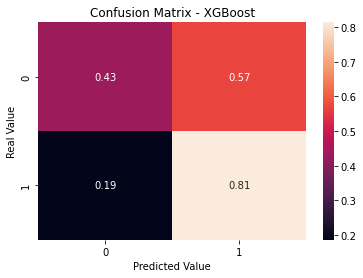

In [34]:
# FINAL XGBoost MODEL
xgb = XGBClassifier(max_depth=3, learning_rate=0.0001, n_estimators=50, gamma=1, min_child_weight=6)
xgb.fit(X_train_rus, y_train_rus)

# PREDICTION ON TEST SET
X_test_xgb = scaler.transform(X_test)
y_pred_xgb = xgb.predict(X_test_xgb)

# PRINT CLASSIFICATION REPORT
print(classification_report(y_test, y_pred_xgb))

# GENERATE CONFUSION MATRIC
fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(y_test, y_pred_xgb, normalize='true'), annot=True, ax=ax)
ax.set_title('Confusion Matrix - XGBoost')
ax.set_xlabel('Predicted Value')
ax.set_ylabel('Real Value')

plt.show()

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
              precision    recall  f1-score   support

           0       0.91      0.62      0.73      8771
           1       0.25      0.69      0.37      1665

    accuracy                           0.63     10436
   macro avg       0.58      0.65      0.55     10436
weighted avg       0.81      0.63      0.68     10436



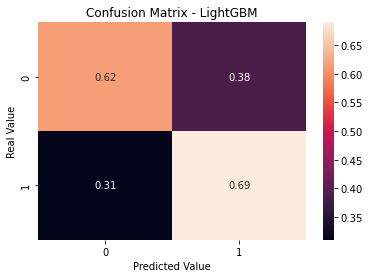

In [35]:
# FINAL LightGBM MODEL
lgb = LGBMClassifier(num_leaves=70, max_depth=5, learning_rate=0.01, min_data_in_leaf=400)
lgb.fit(X_train_rus, y_train_rus)

# PREDICTION ON TEST SET
X_test_lgb = scaler.transform(X_test)
y_pred_lgb = lgb.predict(X_test_lgb)

# PRINT CLASSIFICATION REPORT
print(classification_report(y_test, y_pred_lgb))

# GENERATE CONFUSION MATRIC
fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(y_test, y_pred_lgb, normalize='true'), annot=True, ax=ax)
ax.set_title('Confusion Matrix - LightGBM')
ax.set_xlabel('Predicted Value')
ax.set_ylabel('Real Value')

plt.show()

              precision    recall  f1-score   support

           0       0.91      0.64      0.75      8771
           1       0.26      0.66      0.37      1665

    accuracy                           0.64     10436
   macro avg       0.58      0.65      0.56     10436
weighted avg       0.80      0.64      0.69     10436



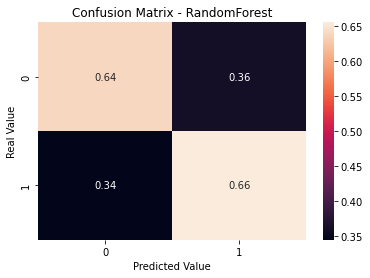

In [46]:
# FINAL RandomForestClassifier MODEL
rfc = RandomForestClassifier(n_estimators=150)
rfc.fit(X_train_rus, y_train_rus)

# PREDICTION ON TEST SET
X_test_cb = scaler.transform(X_test)
y_pred_cb = rfc.predict(X_test_cb)

# PRINT CLASSIFICATION REPORT
print(classification_report(y_test, y_pred_cb))

# GENERATE CONFUSION MATRIX
fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(y_test, y_pred_cb, normalize='true'), annot=True, ax=ax)
ax.set_title('Confusion Matrix - RandomForest')
ax.set_xlabel('Predicted Value')
ax.set_ylabel('Real Value')

plt.show()